In [1]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import pandas as pd
import seaborn as sns

In [2]:
evals = [
    "../workflow/heilbron2022/evaluations/shift075_vs_baseline/EleutherAI/gpt-neo-2.7B/n10000/test_scores.csv",
    "../workflow/heilbron2022/evaluations/variable_vs_baseline/EleutherAI/gpt-neo-2.7B/n10000/test_scores.csv",
]

montage = "biosemi128"

In [3]:
sns.set(style="whitegrid", font_scale=2)

In [4]:
converters = {"model_run": ast.literal_eval}
index_cols = ["model_run", "subject", "run", "sensor"]
eval_dfs = [pd.read_csv(eval_, converters=converters, index_col=index_cols)
            for eval_ in evals]

In [5]:
sensors = sorted(set(eval_dfs[0].index.get_level_values("sensor")))
for eval_df in eval_dfs[1:]:
    assert sensors == sorted(set(eval_df.index.get_level_values("sensor")))

In [6]:
common_models = None
for eval_df in eval_dfs:
    eval_df_models = set(eval_df.index.get_level_values("model_run").unique())
    if common_models is None:
        common_models = eval_df_models
    else:
        common_models &= eval_df_models

assert len(common_models) == 1
base_model = next(iter(common_models))
base_model

('_wide', 'trf')

In [7]:
eval_df_all = pd.concat(eval_dfs)
eval_df_all = eval_df_all[~eval_df_all.index.duplicated(keep="first")]
eval_df_all

score
model_run                                          subject run                    sensor          
(_wide, trf)                                       1       run1/slice:17214:22949 A19    -0.000624
                                                                                  A7     -0.006729
                                                                                  B22     0.077013
                                                                                  B4      0.028612
                                                                                  C10     0.093331
...                                                                                            ...
(_cannon_wide, trf-berp-cannon_3quantiles.29720... 9       run9/slice:16884:22511 B4      0.043816
                                                                                  C10     0.101246
                                                                                  C22     0.117013
                                                                                  C32     0.083579
                                                                                  D19     0.079904

[8664 rows x 1 columns]

## Spaghetti by subject

In [8]:
plot_df = eval_df_all.groupby(["model_run", "subject"]).mean().reset_index().astype(dict(model_run="str", subject="str"))
plot_df.head()

,model_run,subject,score
0,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",1,0.038934
1,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",2,0.049604
2,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",3,0.016867
3,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",4,0.049214
4,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",5,0.068397


[Text(0, 0, "('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')"),
 Text(1, 0, "('_wide', 'trf')"),
 Text(2, 0, "('_wide', 'trf-berp-fixed-t075')")]

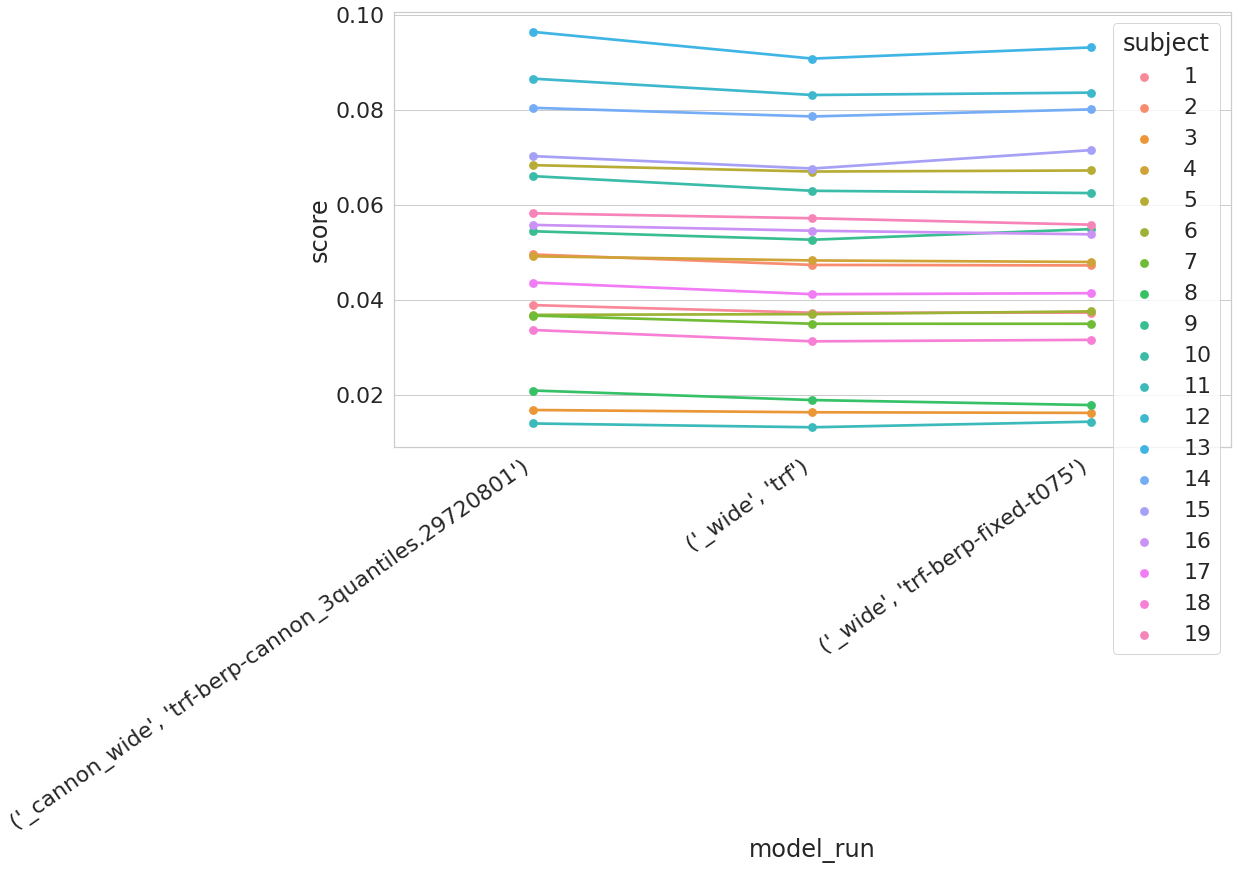

In [9]:
f, ax = plt.subplots(figsize=(15, 8))
sns.pointplot(data=plot_df, x="model_run", y="score", hue="subject", ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")

In [10]:
plot_df_baseline = eval_df_all.groupby(["model_run", "subject"]).mean()
plot_df_baseline = plot_df_baseline.score.sub(plot_df_baseline.groupby("subject").score.mean())
plot_df_baseline = plot_df_baseline.reset_index().astype(dict(model_run="str", subject="str"))
plot_df_baseline.head()

,model_run,subject,score
0,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",1,0.001055
1,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",2,0.001504
2,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",3,0.000360
3,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",4,0.000688
4,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",5,0.000821


In [11]:
# Show upper 25% of subjects for each run
from io import StringIO
out=StringIO()
plot_df_baseline.groupby("model_run").apply(lambda xs: xs.sort_values("score", ascending=False).head(int(0.25 * len(xs)))).to_csv(out)

In [12]:
print(out.getvalue())

model_run,,model_run,subject,score
"('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')",12,"('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')",13,0.002957491387190342
"('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')",9,"('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')",10,0.0022101912255062667
"('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')",11,"('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')",12,0.002123859958948371
"('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')",7,"('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')",8,0.0016885949150268406
"('_wide', 'trf')",37,"('_wide', 'trf')",19,0.00010177339960424497
"('_wide', 'trf')",21,"('_wide', 'trf')",3,-0.00011524927070863042
"('_wide', 'trf')",24,"('_wide', 'trf')",6,-0.0001407887716675521
"('_wide', 'trf')",34,"('_wide', 'trf')",16,-0.00015361987244321557
"('_wide', 'trf-berp-fixed-t075')",52,"('_wide', 'trf-berp-fixed-t075')",15,0.0017172753136388552
"('_wide', 'trf-berp-fixed-t

[Text(0, 0, "('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')"),
 Text(1, 0, "('_wide', 'trf')"),
 Text(2, 0, "('_wide', 'trf-berp-fixed-t075')")]

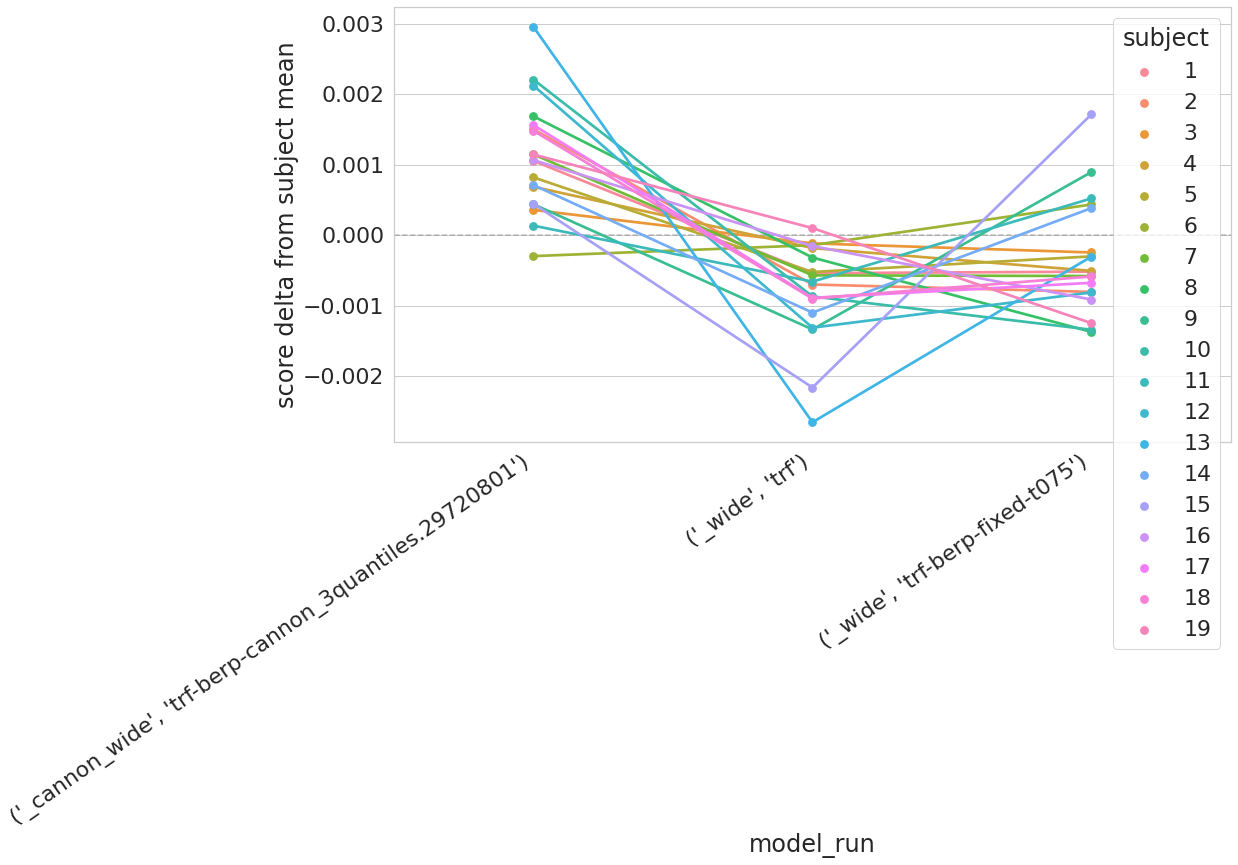

In [13]:
f, ax = plt.subplots(figsize=(15, 8))
ax.axhline(0, c="gray", alpha=0.5, linestyle="--")
sns.pointplot(data=plot_df_baseline, x="model_run", y="score", hue="subject", ax=ax)
ax.set_ylabel("score delta from subject mean")

ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")

[Text(0, 0, "('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')"),
 Text(1, 0, "('_wide', 'trf-berp-fixed-t075')"),
 Text(2, 0, "('_wide', 'trf')")]

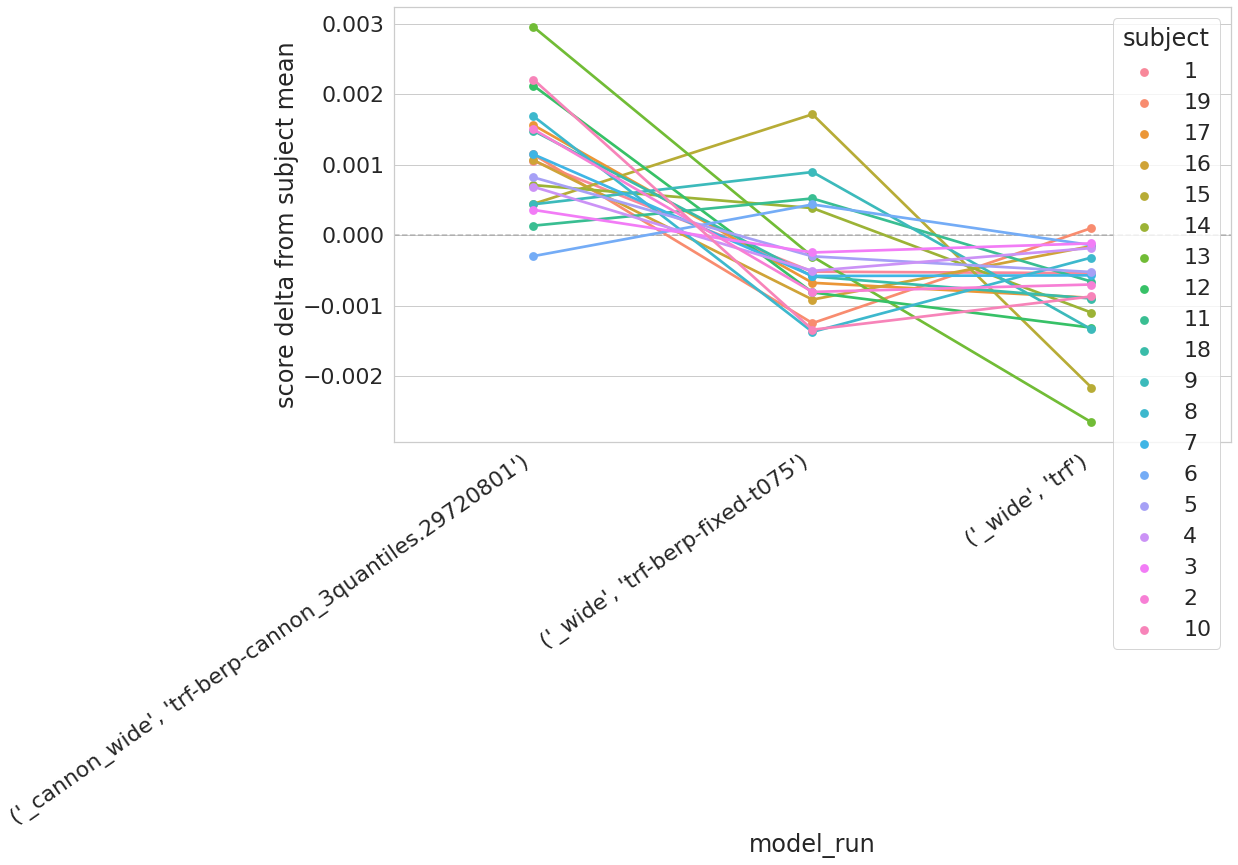

In [14]:
# Reorder to easily compare vanilla vs shift

all_models = list(plot_df_baseline.model_run.unique())

f, ax = plt.subplots(figsize=(15, 8))
ax.axhline(0, c="gray", alpha=0.5, linestyle="--")
sns.pointplot(data=plot_df_baseline.assign(model_run=pd.Categorical(plot_df_baseline.model_run, categories=[all_models[0], all_models[2], all_models[1]])).sort_values("model_run"),
              x="model_run", y="score", hue="subject", ax=ax)
ax.set_ylabel("score delta from subject mean")

ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")

### Spaghetti by subject and sensor

In [15]:
improvements = eval_df_all.drop([base_model], level="model_run") - eval_df_all.loc[base_model]
improvements

score
subject run                    sensor model_run                                                   
1       run1/slice:17214:22949 A19    (_wide, trf-berp-fixed-t075)                       -0.005122
                                      (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.001911
                               A7     (_wide, trf-berp-fixed-t075)                        0.000151
                                      (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.000415
                               B22    (_wide, trf-berp-fixed-t075)                        0.002175
...                                                                                            ...
19      run9/slice:16986:22648 C22    (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.001828
                               C32    (_wide, trf-berp-fixed-t075)                        0.000280
                                      (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.002461
                               D19    (_wide, trf-berp-fixed-t075)                        0.000532
                                      (_cannon_wide, trf-berp-cannon_3quantiles.29720... -0.000003

[5776 rows x 1 columns]

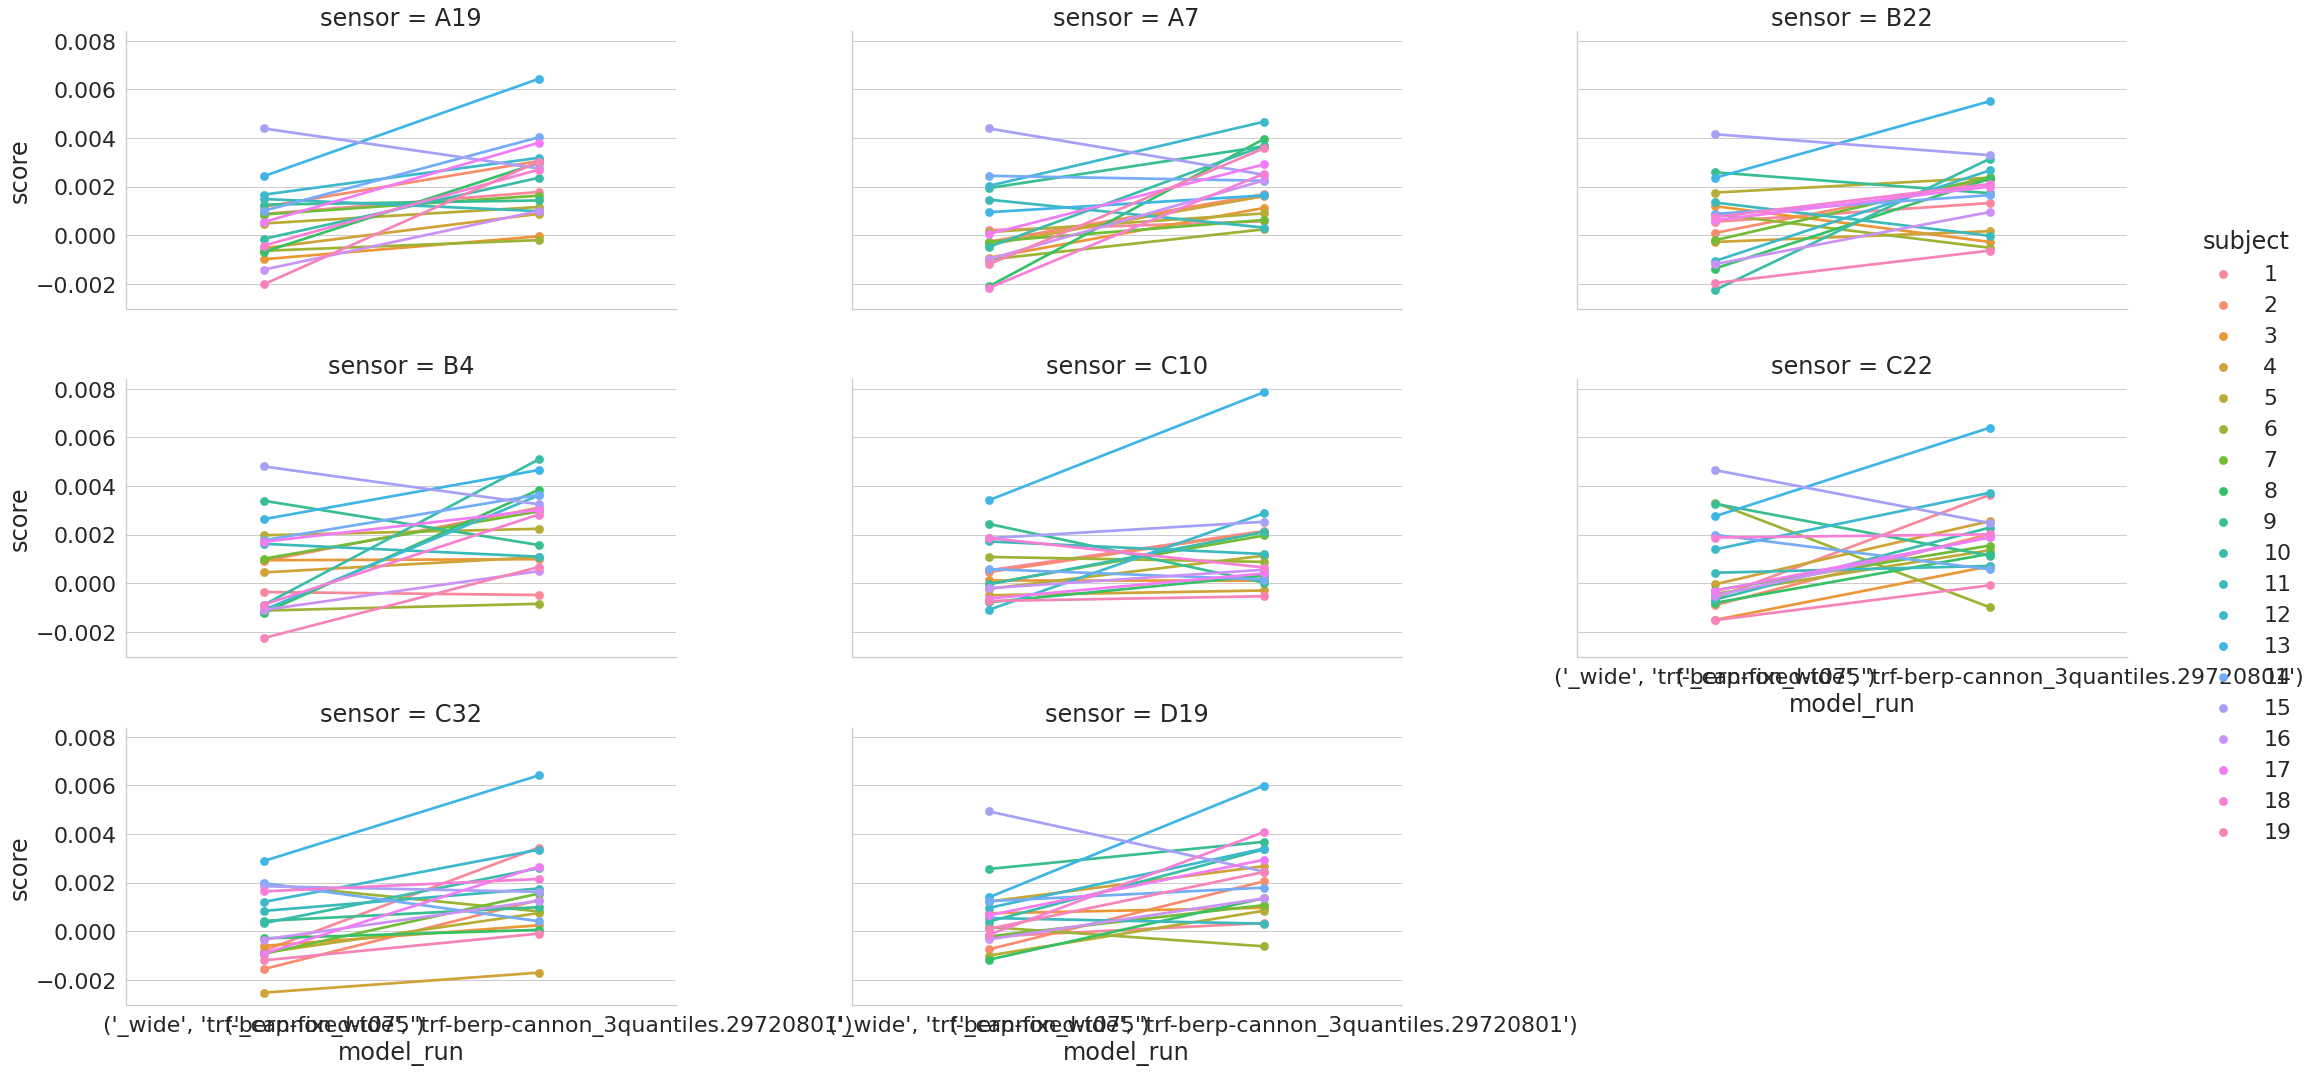

In [16]:
sns.catplot(data=improvements.groupby(["model_run", "subject", "sensor"]).mean().reset_index(),
            kind="point", x="model_run", hue="subject", y="score",
            col="sensor", col_wrap=3, aspect=2)

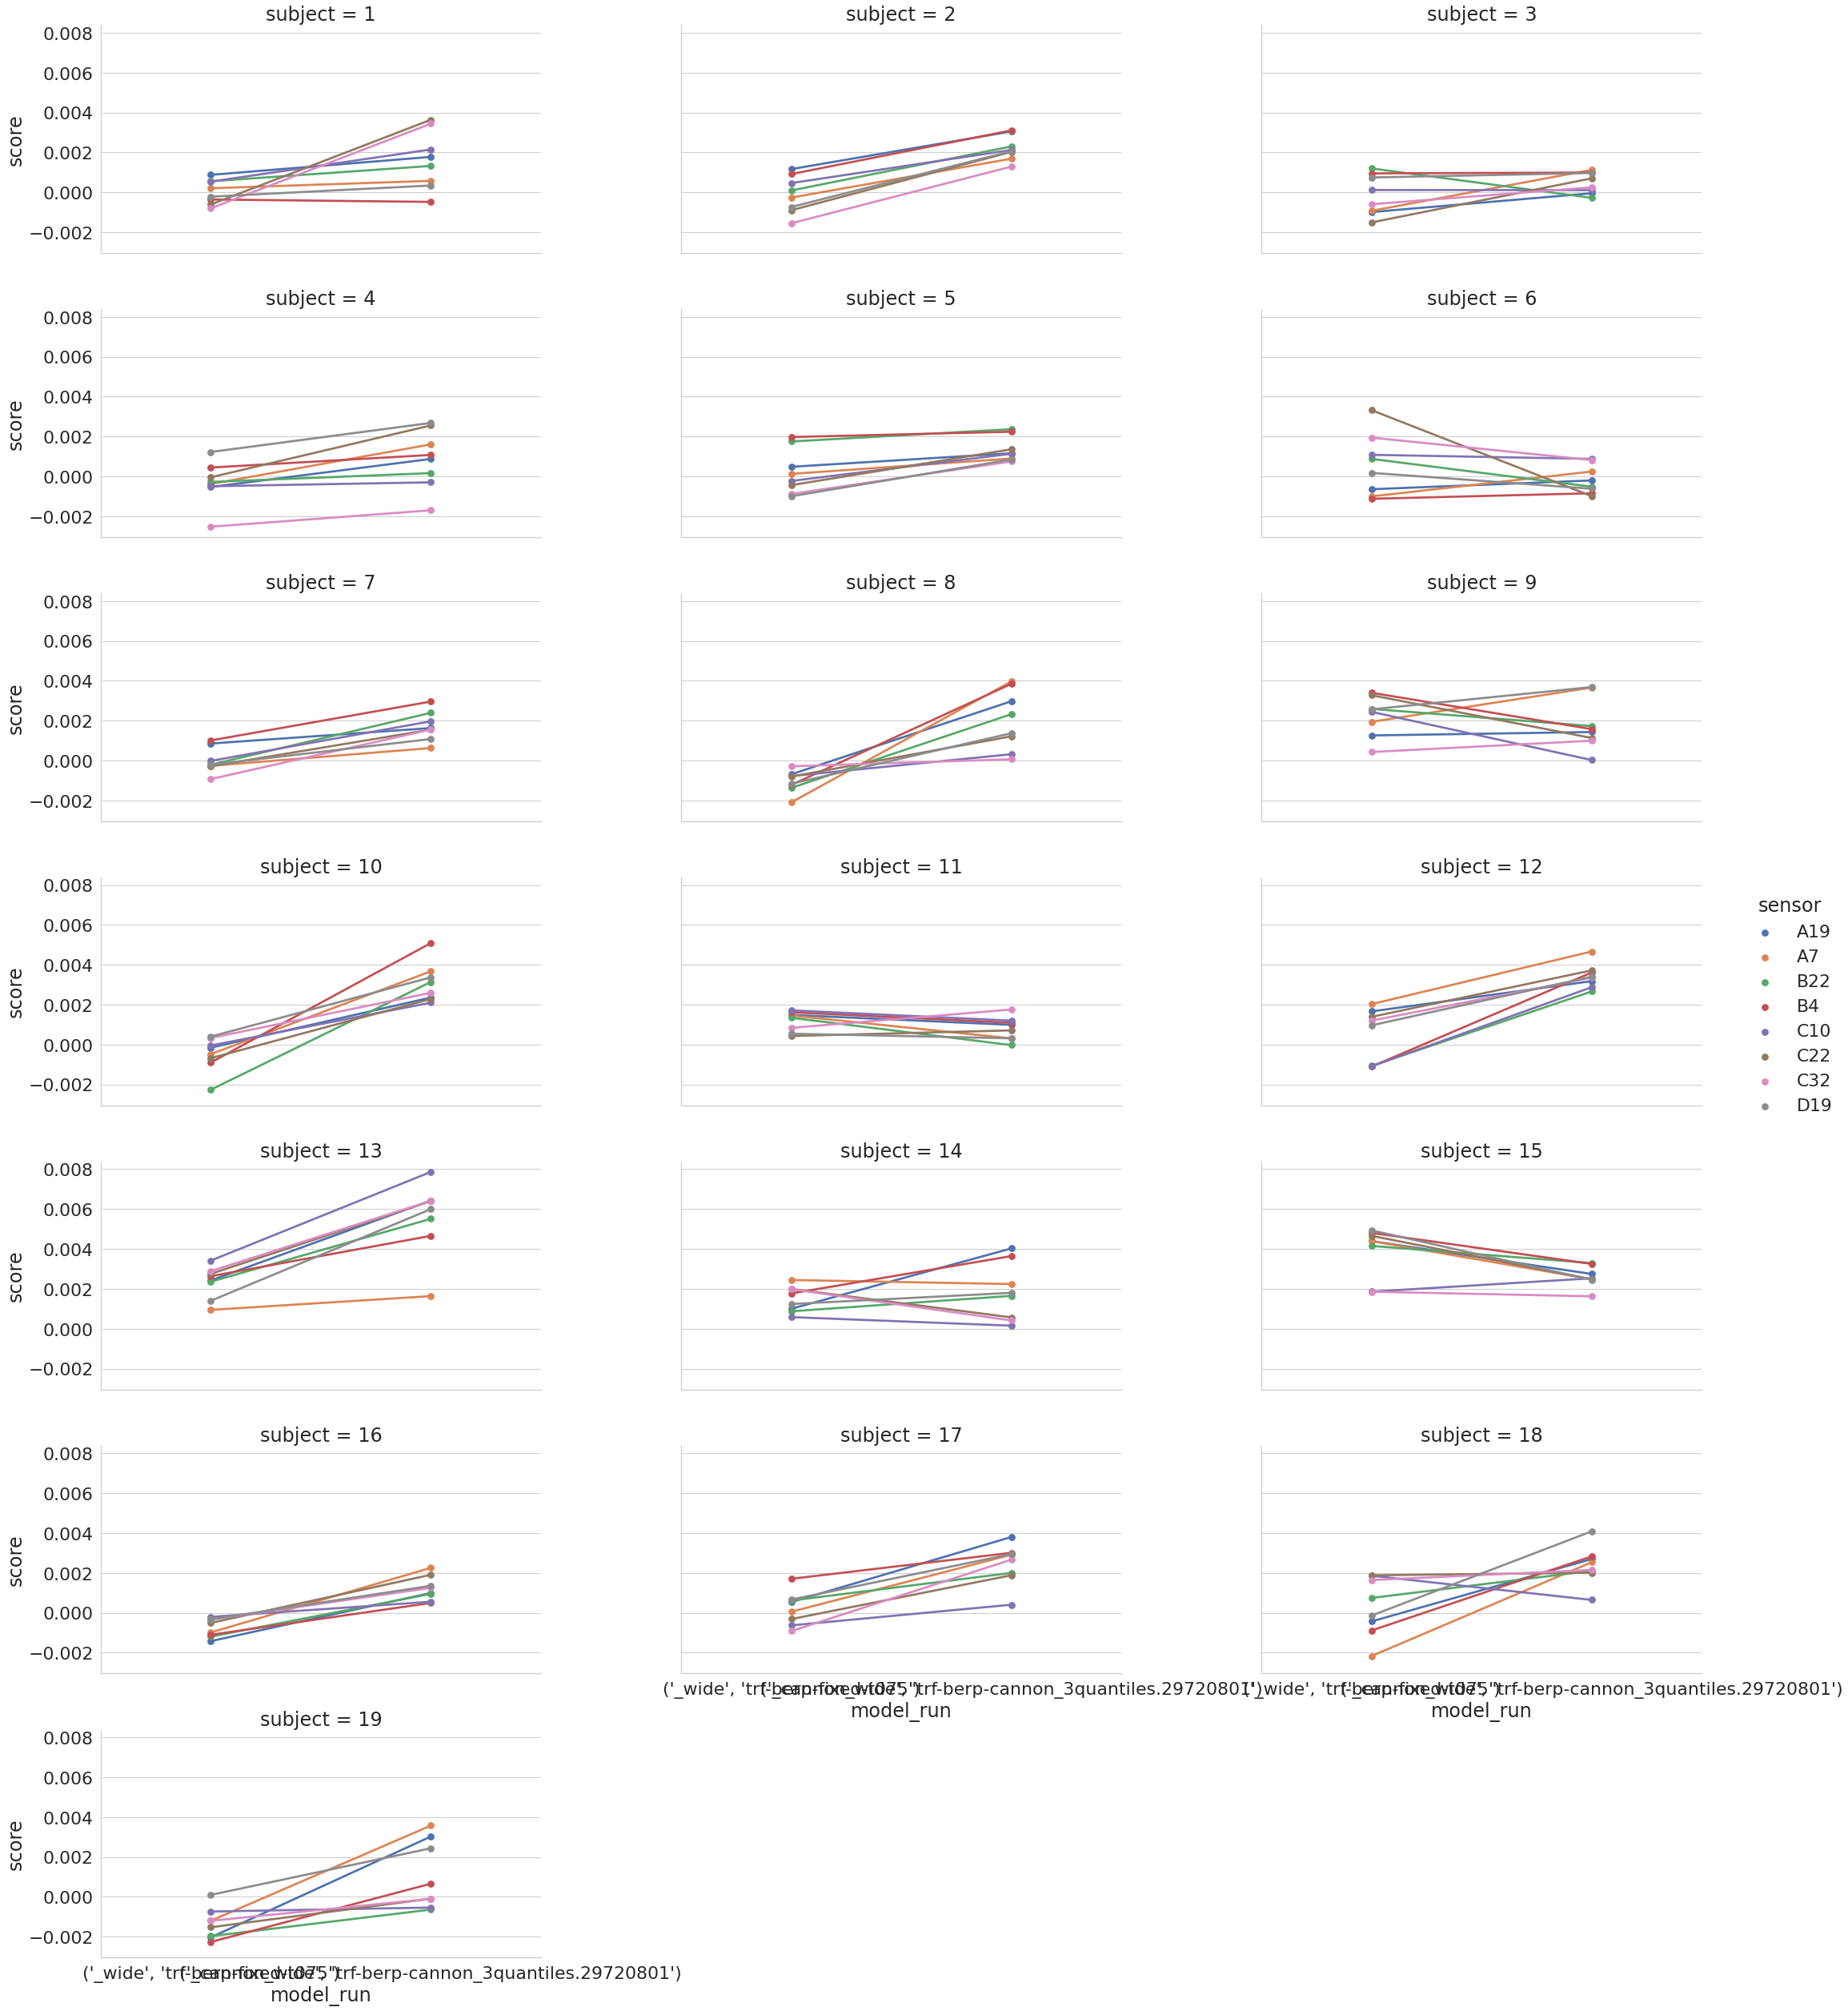

In [17]:
sns.catplot(data=improvements.groupby(["model_run", "subject", "sensor"]).mean().reset_index(),
            kind="point", x="model_run", hue="sensor", y="score",
            col="subject", col_wrap=3, aspect=2)

In [18]:
improvements.loc[18].groupby(["sensor", "model_run"]).mean()

score
sensor model_run                                                   
A19    (_wide, trf-berp-fixed-t075)                       -0.000431
       (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.002695
A7     (_wide, trf-berp-fixed-t075)                       -0.002166
       (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.002534
B22    (_wide, trf-berp-fixed-t075)                        0.000745
       (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.002105
B4     (_wide, trf-berp-fixed-t075)                       -0.000885
       (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.002827
C10    (_wide, trf-berp-fixed-t075)                        0.001859
       (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.000647
C22    (_wide, trf-berp-fixed-t075)                        0.001881
       (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.002009
C32    (_wide, trf-berp-fixed-t075)                        0.001642
       (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.002151
D19    (_wide, trf-berp-fixed-t075)                       -0.000137
       (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.004086

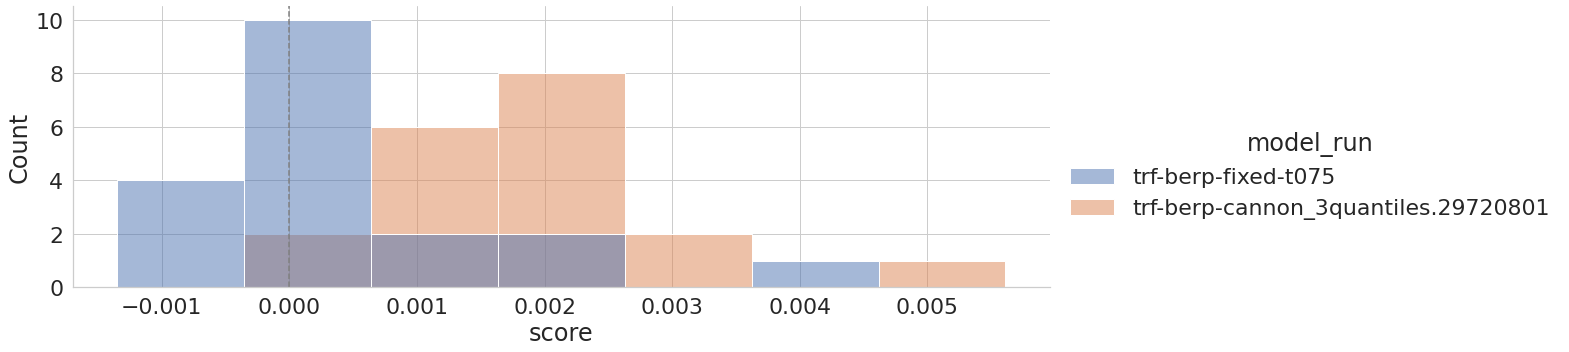

In [19]:
g = sns.displot(data=improvements.groupby(["model_run", "subject"]).mean(), x="score", hue="model_run", aspect=3)
g.axes.ravel()[0].axvline(0, c="gray", linestyle="--")

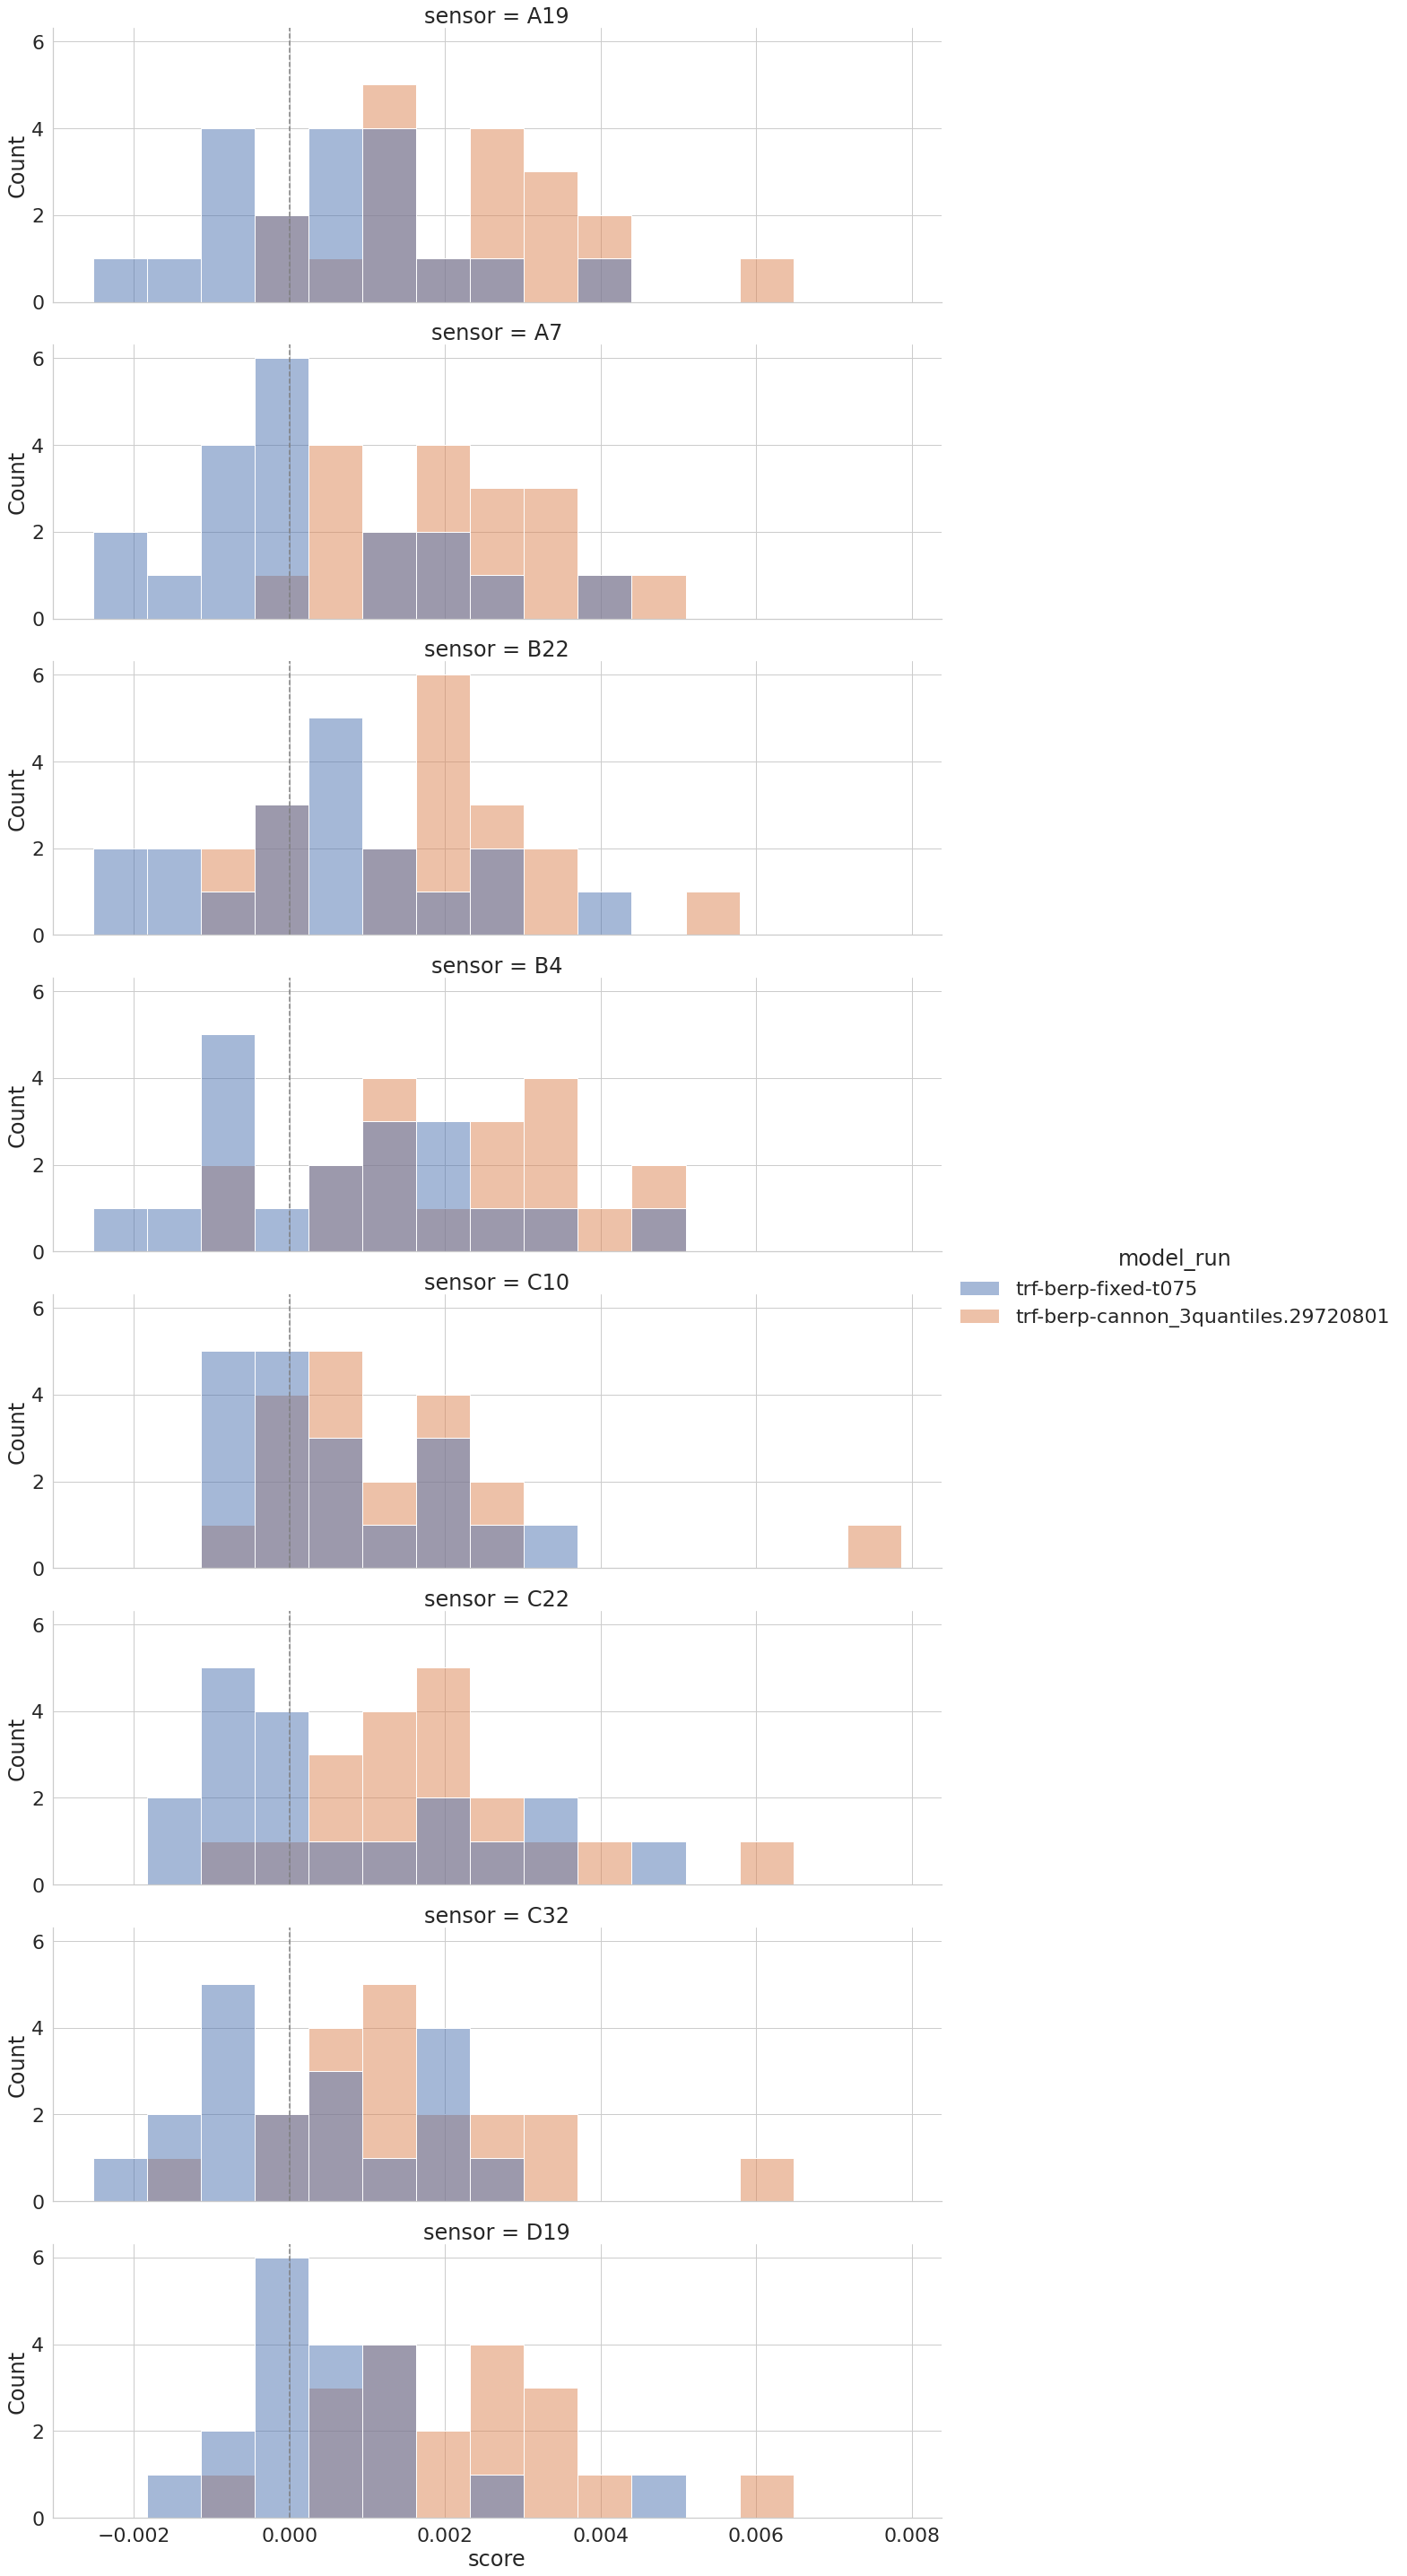

In [20]:
g = sns.displot(data=improvements.groupby(["model_run", "subject", "sensor"]).mean().reset_index(),
                x="score", hue="model_run", row="sensor", aspect=3)
for ax in g.axes.ravel():
    ax.axvline(0, c="gray", linestyle="--")

## Spaghetti by sensor

In [21]:
plot_df = eval_df_all.groupby(["model_run", "sensor"]).mean().reset_index().astype(dict(model_run="str"))
plot_df.head()

,model_run,sensor,score
0,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",A19,0.049010
1,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",A7,0.043495
2,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",B22,0.059095
3,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",B4,0.048523
4,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",C10,0.051142


In [22]:
plot_df_baseline = eval_df_all.groupby(["model_run", "sensor"]).mean()
plot_df_baseline = plot_df_baseline.score.sub(plot_df_baseline.groupby("sensor").score.mean())
plot_df_baseline = plot_df_baseline.reset_index().astype(dict(model_run="str"))
plot_df_baseline.head()

,model_run,sensor,score
0,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",A19,0.001343
1,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",A7,0.001360
2,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",B22,0.000984
3,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",B4,0.001286
4,"('_cannon_wide', 'trf-berp-cannon_3quantiles.2...",C10,0.000746


[Text(0, 0, "('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')"),
 Text(1, 0, "('_wide', 'trf')"),
 Text(2, 0, "('_wide', 'trf-berp-fixed-t075')")]

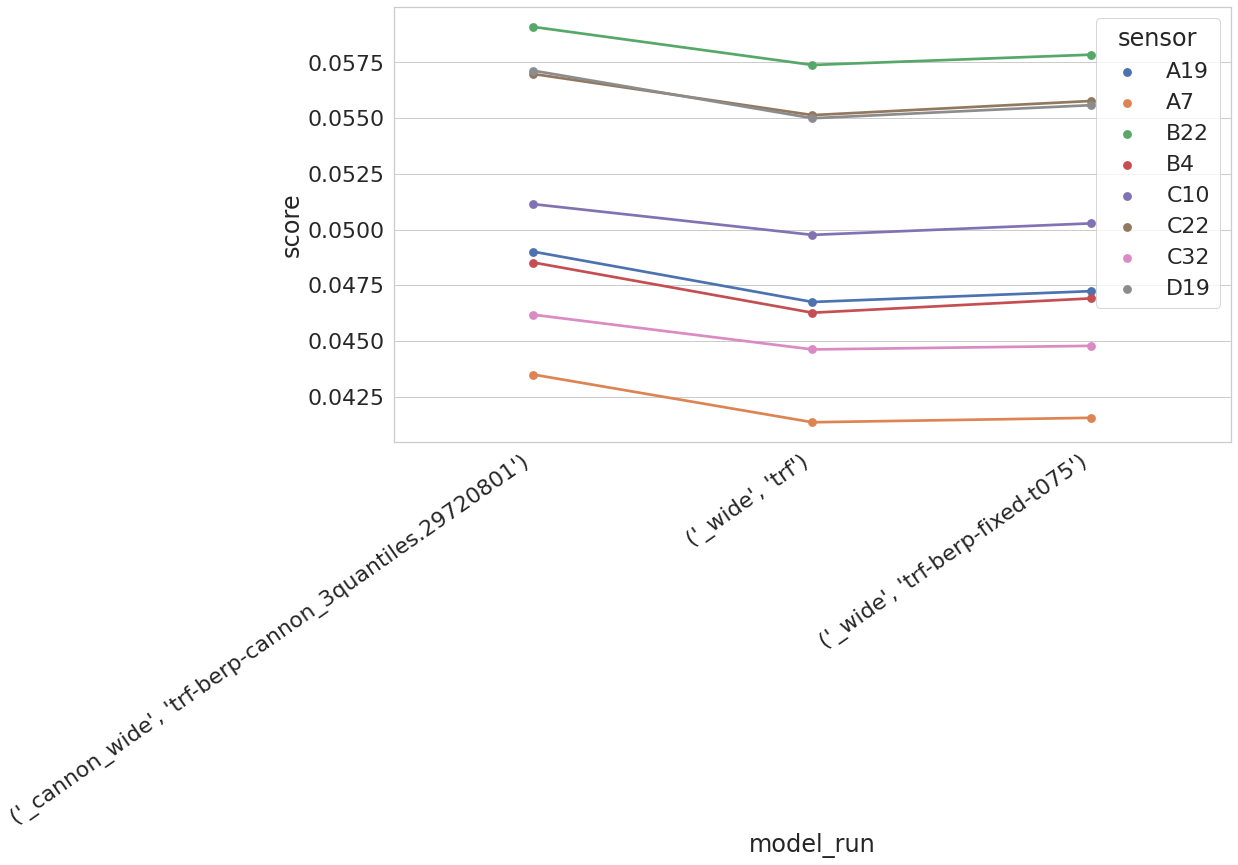

In [23]:
f, ax = plt.subplots(figsize=(15, 8))
sns.pointplot(data=plot_df, x="model_run", y="score", hue="sensor", ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")

[Text(0, 0, "('_cannon_wide', 'trf-berp-cannon_3quantiles.29720801')"),
 Text(1, 0, "('_wide', 'trf')"),
 Text(2, 0, "('_wide', 'trf-berp-fixed-t075')")]

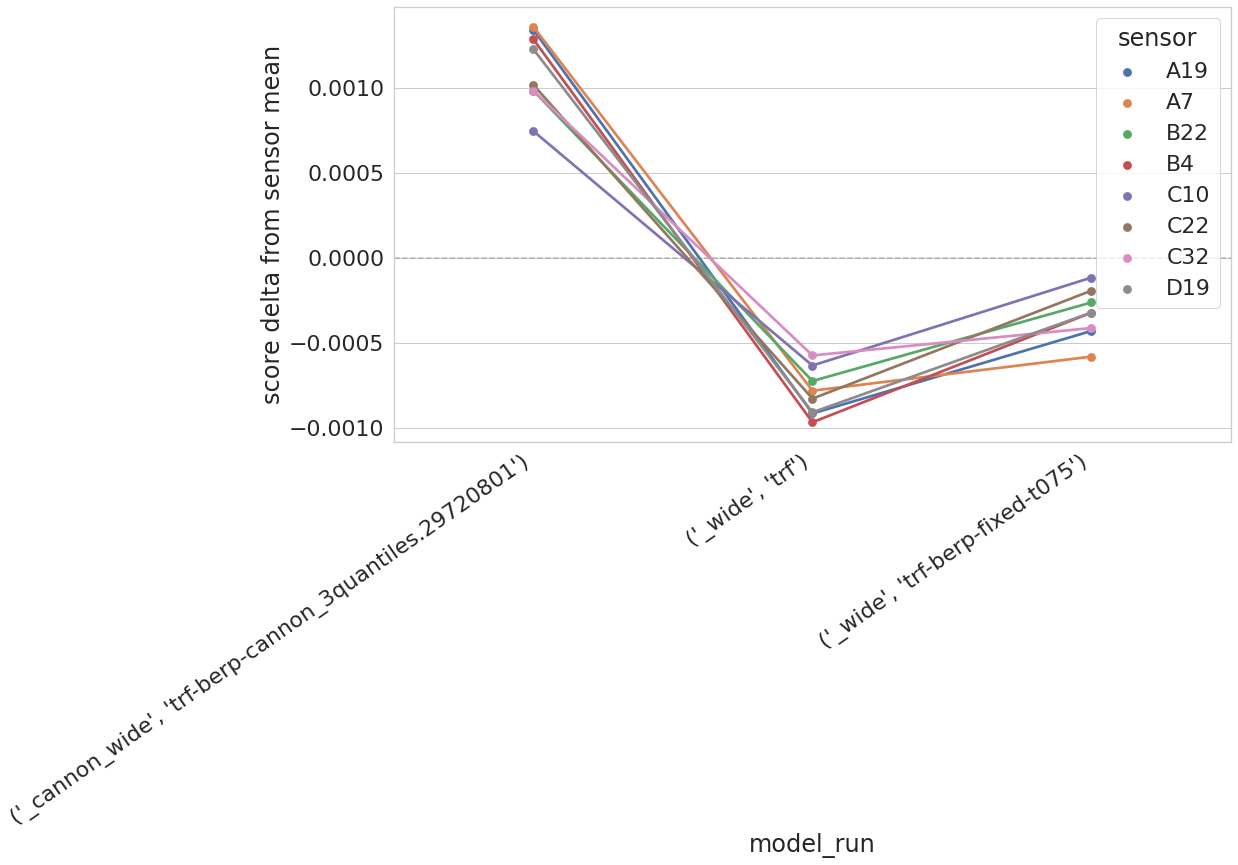

In [24]:
f, ax = plt.subplots(figsize=(15, 8))
ax.axhline(0, c="gray", alpha=0.5, linestyle="--")
sns.pointplot(data=plot_df_baseline, x="model_run", y="score", hue="sensor", ax=ax)
ax.set_ylabel("score delta from sensor mean")

ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")

In [25]:
improvements = eval_df_all.drop([base_model], level="model_run") - eval_df_all.loc[base_model]
improvements

score
subject run                    sensor model_run                                                   
1       run1/slice:17214:22949 A19    (_wide, trf-berp-fixed-t075)                       -0.005122
                                      (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.001911
                               A7     (_wide, trf-berp-fixed-t075)                        0.000151
                                      (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.000415
                               B22    (_wide, trf-berp-fixed-t075)                        0.002175
...                                                                                            ...
19      run9/slice:16986:22648 C22    (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.001828
                               C32    (_wide, trf-berp-fixed-t075)                        0.000280
                                      (_cannon_wide, trf-berp-cannon_3quantiles.29720...  0.002461
                               D19    (_wide, trf-berp-fixed-t075)                        0.000532
                                      (_cannon_wide, trf-berp-cannon_3quantiles.29720... -0.000003

[5776 rows x 1 columns]

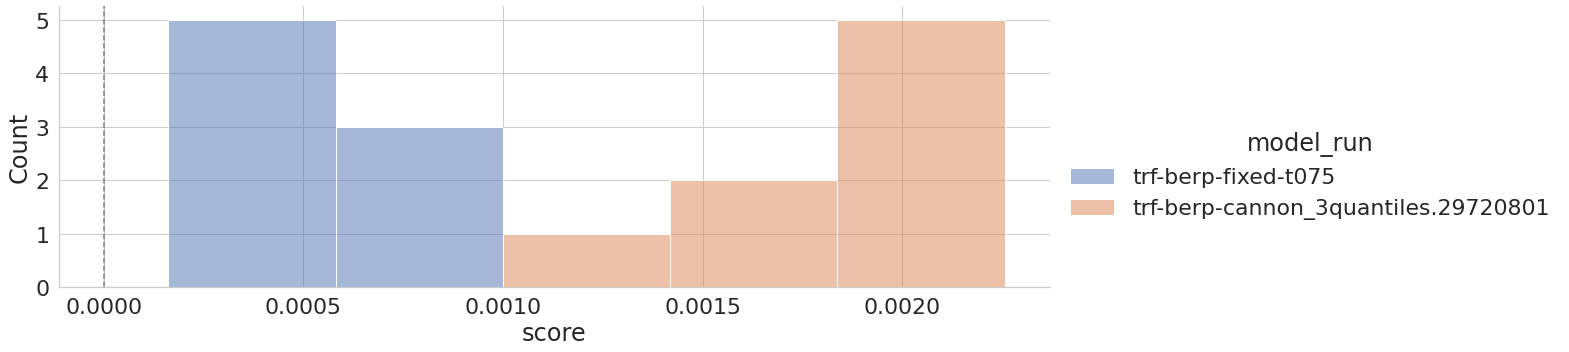

In [26]:
g = sns.displot(data=improvements.groupby(["model_run", "sensor"]).mean(), x="score", hue="model_run", aspect=3)
g.axes.ravel()[0].axvline(0, c="gray", linestyle="--")